# Model explanation

This notebook is a model interpretability notebook for the OPERA dataset. It:

- Loads the OPERA dataset and prepares features/labels.
- Trains an XGBoost classifier (binary classification: OPERA outcome).
- Evaluates the model with ROC-AUC.
- Explains the model with SHAP:
    - global explanations (feature importance)
    - local explanations (per-patient prediction explanation)
    - waterfall plots
    - SHAP values summary
    - scatter plots for individual features
    - interaction effects (if computed)
- Explains the model with LIME:
    - Local explanations of individual predictions using a surrogate interpretable model
    - Identifies key features contributing to specific predictions
    - Visualizes the importance of features for particular instances
    - Provides visual, intuitive insight into why the trained model makes its predictions.

We can use SHAP/LIME values to find out:
- which biomarkers/features are important
- how they increase or decrease risk/probability
- how individual patient-level predictions are formed


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import shap
import xgboost

!pip install lime
from lime import lime_tabular

In [3]:
# Load input dataset

df = pd.read_csv("../data/OPERA.csv", index_col=[0,1])
df.index = df.index.droplevel(level=0)

df = df.transpose()
df.head()

targets = ['BPISeverityChange','BPIInterferenceChange', 
           'ChangeGrandTotalMedicines','ChangeInTotalComplaintsNotIncludingOther']
X = df.drop(columns=targets)
Y = df[targets]

y = df['BPISeverityChange']
X = df.drop(columns=targets)

In [4]:
# Deal with features that are highly correlated (forms clusters on the correlation heatmap)
# Pick 1–2 representative features per correlated block

def remove_correlated_features(X, y, corr_threshold=0.8):
    """
    Iteratively remove features that are too correlated with each other.
    Between each correlated pair, we drop the one less correlated with y.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (no target column).
    y : pd.Series or 1D array
        Target variable.
    corr_threshold : float
        Absolute correlation threshold above which we consider features "too correlated".
    
    Returns
    -------
    kept_columns : list
        List of feature names kept.
    dropped_columns : list
        List of dropped feature names.
    """
    X_corr = X.corr().abs().copy()
    
    # Correlation of each feature with the target (for deciding which to keep)
    corr_with_y = X.apply(lambda col: col.corr(y)).abs()
    
    # We’ll work on a copy of the column names
    cols = list(X_corr.columns)
    dropped = []

    # Set diagonal to 0 so we don’t pick self-correlation
    np.fill_diagonal(X_corr.values, 0.0)
    
    while True:
        # Find the pair with maximum correlation
        max_corr = X_corr.values.max()
        if max_corr < corr_threshold:
            break  # we're done
        
        # indices of the max correlation
        i, j = np.where(X_corr.values == max_corr)
        i, j = i[0], j[0]
        
        col_i = cols[i]
        col_j = cols[j]
        
        # Decide which one to drop: keep the one more correlated with y
        if corr_with_y[col_i] < corr_with_y[col_j]:
            col_to_drop = col_i
        else:
            col_to_drop = col_j
        
        dropped.append(col_to_drop)
        
        # Remove from correlation matrix & lists
        drop_idx = cols.index(col_to_drop)
        cols.pop(drop_idx)
        X_corr = X_corr.drop(index=col_to_drop, columns=col_to_drop)
        
        # also drop from corr_with_y
        corr_with_y = corr_with_y.drop(col_to_drop)
        
        # reset diagonal to 0 after shape changed
        np.fill_diagonal(X_corr.values, 0.0)
    
    kept = cols
    return kept, dropped

kept_cols, dropped_cols = remove_correlated_features(X, y, corr_threshold=0.8)

print("Kept:", kept_cols)
print("Dropped:", dropped_cols)

X_reduced = X[kept_cols]

Kept: ['Age', 'Gender', 'Overall_Pain_interference', 'Int_Gen_Activity', 'Int_Mood', 'Int_Walking_ability', 'Int_Work', 'Int_Relationship', 'Int_Sleep', 'Arthritis_bin', 'Arthritis_categ', 'Int_Life_enjoyment', 'Meds_3days', 'Categ_of_meds', 'OTC_bin', 'OTC_categ', 'AntiInflam_categ', 'Narcotic_categ', 'NeuroRadic_bin', 'NeuroRadic_cat', 'MyoMuscul_cat', 'MyoMuscul_bin', 'Tendinitis_cat', 'Other_cat', 'Pain_other', 'Worst_24h', 'Grand_Tot_Compl', 'Not_on_Anticonvulsant', 'Pain_categ', 'Opioid_comb', 'Severity_Score', 'TFFC1', 'TFFC2', 'TFFC3', 'TFFC4']
Dropped: ['AntiInflam_weight', 'Narcotic_weight', 'Tot_Compl_categ', 'Opioid_others', 'Grand_Tot_Med_weight', 'AntiInflam_bin', 'Current_pain', 'Narcotic_bin', 'Other_bin', 'Avg_Interference', 'Tendinitis_bin', 'Average_pain', 'Least_24h', 'Opioids_No_Anticonvulsants', 'Grand_Tot_Med']


In [10]:
Xt, Xv, yt, yv = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

model_xgb = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=3,
                                  early_stopping_rounds=10 ,
                                  eval_metric= 'auc')
model_xgb.fit(Xt, yt, 
              eval_set=[(Xt, yt),(Xv, yv)],
              verbose=True)

[0]	validation_0-auc:0.69511	validation_1-auc:0.69536
[1]	validation_0-auc:0.77488	validation_1-auc:0.75275
[2]	validation_0-auc:0.84055	validation_1-auc:0.74811
[3]	validation_0-auc:0.85284	validation_1-auc:0.73333
[4]	validation_0-auc:0.87592	validation_1-auc:0.72405
[5]	validation_0-auc:0.87685	validation_1-auc:0.71306
[6]	validation_0-auc:0.89295	validation_1-auc:0.70859
[7]	validation_0-auc:0.90479	validation_1-auc:0.72199
[8]	validation_0-auc:0.91984	validation_1-auc:0.73299
[9]	validation_0-auc:0.92441	validation_1-auc:0.73780
[10]	validation_0-auc:0.92684	validation_1-auc:0.72955
[11]	validation_0-auc:0.93776	validation_1-auc:0.72491


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
roc_auc_score( yv, model_xgb.predict_proba(Xv)[:,1] )

np.float64(0.7527491408934708)

## SHAP basic usage and plots

In [16]:
%time explainer = shap.Explainer( model_xgb ) ## creates an explainer from our model
%time shap_values = explainer(Xt) ## compute shap values for the prediction of the models on some data

print(explainer)

CPU times: user 120 ms, sys: 946 μs, total: 121 ms
Wall time: 25.9 ms
CPU times: user 254 ms, sys: 26 μs, total: 254 ms
Wall time: 54 ms


In [17]:
print(shap_values)

.values =
array([[-0.00387936,  0.        ,  0.09052997, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00675983,  0.        , -0.01755808, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00675983,  0.        , -0.09302312, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.03809262,  0.        , -0.06050066, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00387936,  0.        ,  0.11644426, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00675983,  0.        , -0.06392635, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

.base_values =
array([-1.3768342, -1.3768342, -1.3768342, -1.3768342, -1.3768342,
       -1.3768342, -1.3768342, -1.3768342, -1.3768342, -1.3768342,
       -1.3768342, -1.3768342, -1.3768342, -1.3768342, -1.3768342,
       -1.3768342, -1.3768342, -1.3768342, -1.3768342, -1.3768342,
       -1.3768342, -1.3768342, -1.3768342, -1.3768342, -1.3768342,
       -1.3

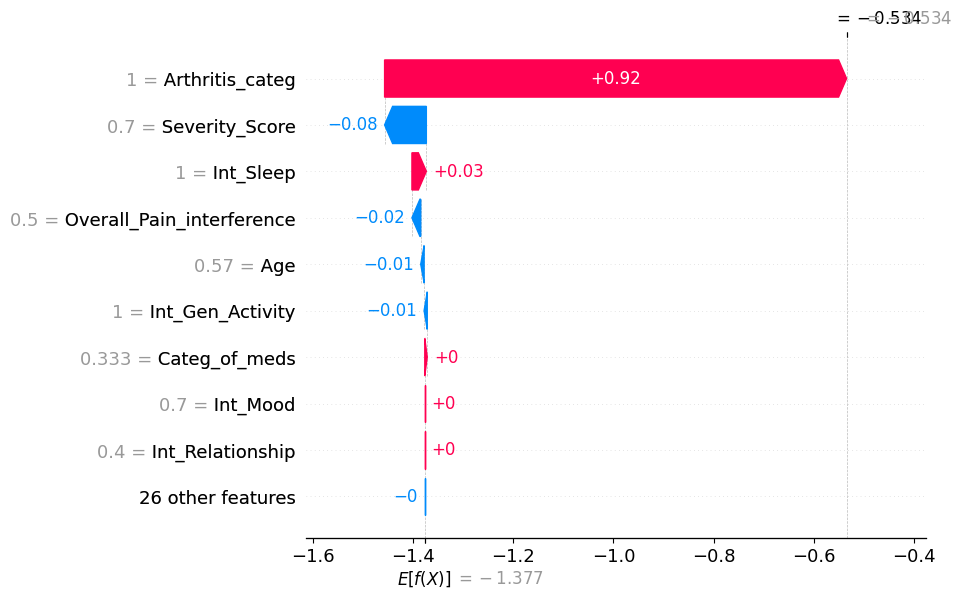

In [ ]:
## explaination of a single prediction. It shows how each feature contributes to prediction for one OPERA patient.

## try with 0 , 1 ,19 ,25 ,26
shap.plots.waterfall(shap_values[1])

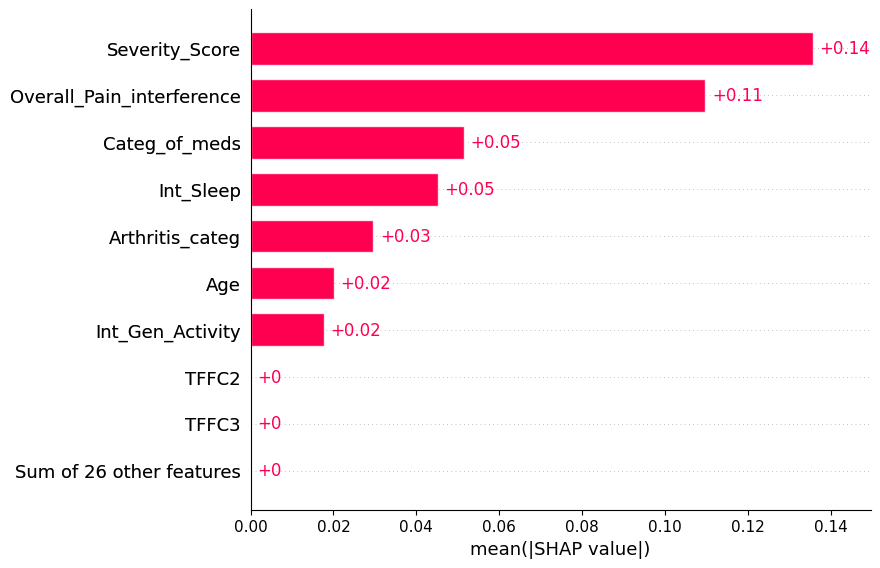

In [ ]:
## average SHAP value over all predictions --> proxy of feature importance. It shows mean absolute SHAP value per feature (which variables matter most).
shap.plots.bar(shap_values)

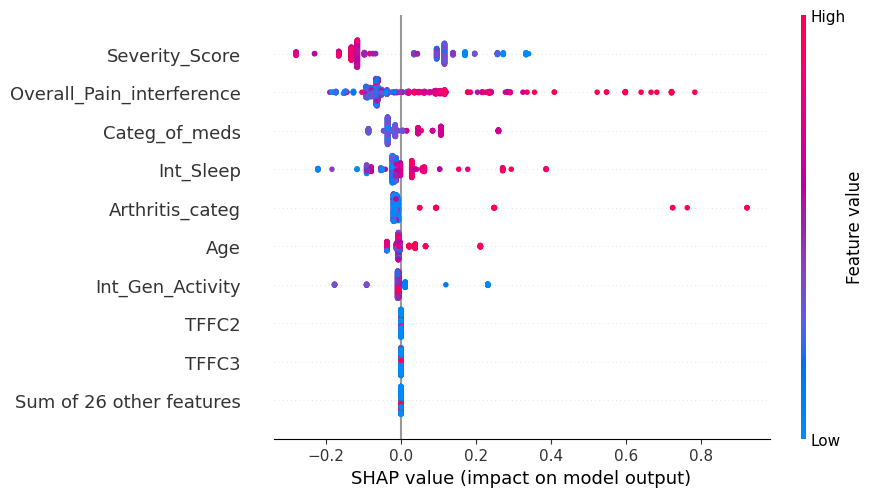

In [ ]:
# beeswarm gives us a sense of the relationship between the feature values and the SHAP
# Shows distribution of SHAP values → how each feature influences predictions across all patients.
shap.plots.beeswarm(shap_values)

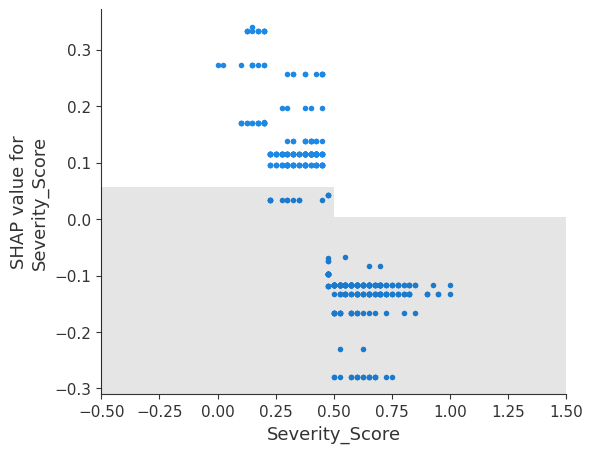

In [21]:
## plotting the SHAP value for each observed age
shap.plots.scatter( shap_values[:,'Severity_Score'] )

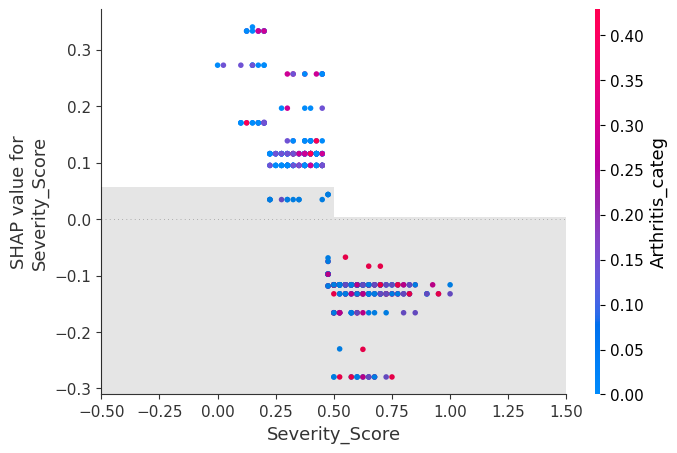

In [25]:
## If you give all shap_values, the library searched for the one which may interact the most
shap.plots.scatter( shap_values[:,'Severity_Score'] , color=shap_values[:,'Arthritis_categ'] )

## SHAP interaction values

CPU times: user 3.1 s, sys: 22.2 ms, total: 3.12 s
Wall time: 640 ms


<Axes: >

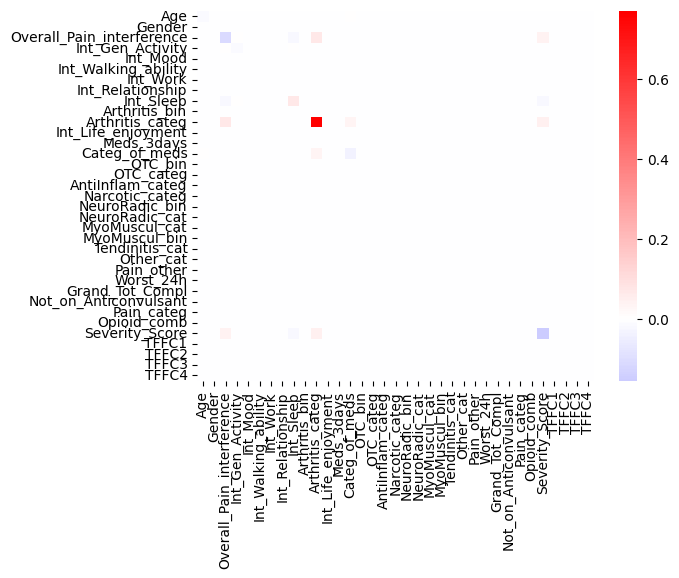

In [23]:
%%time
shap_interaction_values = explainer.shap_interaction_values(Xt)
sns.heatmap( shap_interaction_values[1], 
            xticklabels = Xt.columns,
            yticklabels = Xt.columns,
           center = 0, cmap = 'bwr')

/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 9 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 16 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
 63

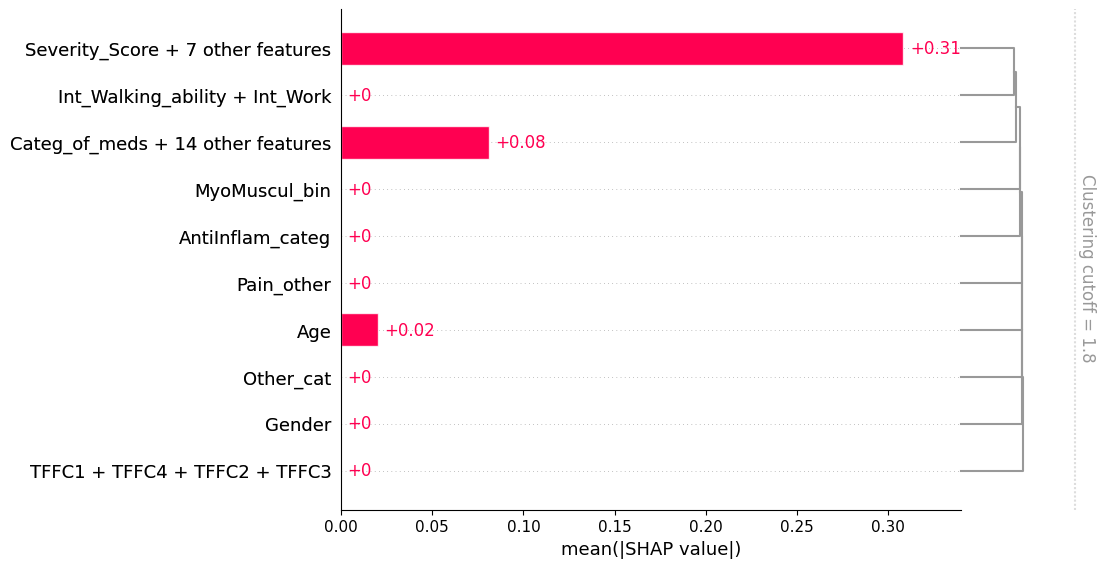

In [26]:
# Clustering
clustering = shap.utils.hclust(Xt, yt)
shap.plots.bar(shap_values, clustering=clustering,clustering_cutoff=1.8)

### Let's try different explainer types

In [ ]:
model_xgb2 = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=1,
                                  early_stopping_rounds=10 ,
                                  eval_metric= 'auc')
model_xgb2.fit(Xt, yt, 
              eval_set=[(Xt, yt),(Xv, yv)],
              verbose=True)

explainer = shap.Explainer( model_xgb2 ) ## defaults to TreeExplainer
print(type(explainer))
# TreeExplainer: 
#  * explores the tree ensemble to compute the SHAP values efficiently
#  * somewhat built-in the trees libraries nowadays -> extra fast computation
shap_values = explainer(Xt) 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


Xt_scaled = StandardScaler().fit_transform(Xt)

LR = LogisticRegression()
LR.fit(Xt_scaled, yt)


explainer = shap.Explainer(LR.predict_proba, Xt_scaled)  # background data = Xt_scaled
shap_values = explainer(Xt_scaled)


explainer

[0]	validation_0-auc:0.56061	validation_1-auc:0.54725
[1]	validation_0-auc:0.64115	validation_1-auc:0.66065
[2]	validation_0-auc:0.66583	validation_1-auc:0.71375
[3]	validation_0-auc:0.67117	validation_1-auc:0.72577
[4]	validation_0-auc:0.69058	validation_1-auc:0.73608
[5]	validation_0-auc:0.70317	validation_1-auc:0.73832
[6]	validation_0-auc:0.72493	validation_1-auc:0.74639
[7]	validation_0-auc:0.72163	validation_1-auc:0.74364
[8]	validation_0-auc:0.73724	validation_1-auc:0.72835
[9]	validation_0-auc:0.74642	validation_1-auc:0.71735
[10]	validation_0-auc:0.74678	validation_1-auc:0.72251
[11]	validation_0-auc:0.75357	validation_1-auc:0.72251
[12]	validation_0-auc:0.75401	validation_1-auc:0.72079
[13]	validation_0-auc:0.75403	validation_1-auc:0.74158
[14]	validation_0-auc:0.76183	validation_1-auc:0.74072
[15]	validation_0-auc:0.76765	validation_1-auc:0.73969
[16]	validation_0-auc:0.76783	validation_1-auc:0.73969
<class 'shap.explainers._tree.TreeExplainer'>


### Simple permutation explainer

[permutation explainer](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Permutation.html)
 * uses smart permutation scheme to estimate SHAP values
 * needs a "background" sample which is used to "simulate" values for the masked features

An alternative is to explicitely say that it is a Linear model:

In [30]:
explainer = shap.explainers.Linear(LR, Xt_scaled[:100,:])
shap_values = explainer(Xt_scaled[:100,:])

But in some case we won't have a choice and we need to go for a "generic" explainer such as PermutationExplainer

For example, for a KNN:

In [32]:
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(Xt_scaled, yt)

explainer = shap.Explainer( KNN.predict_proba , Xt_scaled[:100,:]) 
shap_values = explainer(Xt_scaled[:100,:]) 

Here is API documentation for [other "explainers"](https://shap.readthedocs.io/en/latest/api.html#explainers), either generic or adapted to specific kind of models.


### Causation, correlation, and interpretation of predictive models

We are sure you have heard it a large number of time, but this message really is really worth repeating.

The SHAP documentation actually proposes an [insightful article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html) on the topic of misleading interpretation.

Our advise is to read it attentively, meditate on the subject, and then read it again.

## LIME

LIME is a model-agnostic interpretability technique. It aims to explain individual predictions of a black-box model (like XGBoost, Logistic Regression, etc.) by approximating the model with a local interpretable surrogate model. 

How LIME works:

1. Model agnostic: LIME can be used for any model type (black-box), so it works with complex models like XGBoost or neural networks, which are difficult to interpret directly.

2. Local explanation: LIME doesn't explain the entire model. Instead, it explains individual predictions. It takes one instance (e.g., one patient in your dataset) and tries to explain why the model gave a particular prediction for that instance.

3. Perturbation: LIME perturbs (changes) the data around the instance of interest to generate new synthetic data points. It then sees how the model behaves on these new points.

4. Surrogate model: After perturbing the data, LIME fits a simple, interpretable model (e.g., a linear regression or decision tree) to this new dataset. The idea is that, in the local region around the instance, the black-box model can be approximated well by this simple model.

5. Interpretation: The coefficients or feature importances of the surrogate model give us insight into the black-box model’s behavior for that specific prediction.


LIME vs SHAP:

- LIME is great for local (individual) explanations and uses an interpretable surrogate model.
- SHAP provides global and local explanations by directly calculating the contribution of each feature to the model's output, using game theory concepts.

In [37]:
explainer = lime_tabular.LimeTabularExplainer( np.array( Xt ) , 
                                                   feature_names=Xt.columns, 
                                                   class_names=['Incorrect','Correct'], 
                                                   discretize_continuous=True)
isCorrect = model_xgb.predict( Xv ) == yv

print("correct positive cases:")
print( np.where( isCorrect * (yv==1) )[0][:5] )

print("correct negative cases:")
print( np.where( isCorrect * (yv==0) )[0][:5] )


print("incorrect positive cases:")
print( np.where( (~isCorrect) * (yv==1) )[0][:5] )

print("incorrect negative cases:")
print( np.where( (~isCorrect) * (yv==0) )[0][:5] )

correct positive cases:
[]
correct negative cases:
[0 1 2 4 5]
incorrect positive cases:
[ 3  6 11 19 23]
incorrect negative cases:
[]


In [39]:
i = 1
exp = explainer.explain_instance(np.array( Xv.iloc[i,:] ) , 
                                 model_xgb.predict_proba, 
                                 num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [40]:
print(exp)
print(exp.as_list(0))

[('0.35 < Severity_Score <= 0.47', -0.025286595346709385), ('Categ_of_meds <= 0.33', 0.02106953415646917), ('0.20 < Overall_Pain_interference <= 0.40', 0.015567578601444965), ('0.10 < Int_Sleep <= 0.50', 0.008054473342143197), ('0.45 < Age <= 0.66', 0.0034408760393466677), ('TFFC3 <= 0.00', -0.0030262231116668574), ('0.20 < Int_Mood <= 0.50', 0.0024797515735924813), ('OTC_categ > 0.25', 0.002200092633784142), ('0.00 < Tendinitis_cat <= 0.20', 0.00208440731707748), ('Other_cat > 0.00', -0.0018709854624386552)]
